# Convolutional Neural Networks

## Project: Write an Algorithm for a Dog Identification App 

---

In this notebook, some template code has already been provided for you, and you will need to implement additional functionality to successfully complete this project. You will not need to modify the included code beyond what is requested. Sections that begin with **'(IMPLEMENTATION)'** in the header indicate that the following block of code will require additional functionality which you must provide. Instructions will be provided for each section, and the specifics of the implementation are marked in the code block with a 'TODO' statement. Please be sure to read the instructions carefully! 

> **Note**: Once you have completed all of the code implementations, you need to finalize your work by exporting the Jupyter Notebook as an HTML document. Before exporting the notebook to html, all of the code cells need to have been run so that reviewers can see the final implementation and output. You can then export the notebook by using the menu above and navigating to **File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question X'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.

>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut.  Markdown cells can be edited by double-clicking the cell to enter edit mode.

The rubric contains _optional_ "Stand Out Suggestions" for enhancing the project beyond the minimum requirements. If you decide to pursue the "Stand Out Suggestions", you should include the code in this Jupyter notebook.



---
### Why We're Here 

In this notebook, you will make the first steps towards developing an algorithm that could be used as part of a mobile or web app.  At the end of this project, your code will accept any user-supplied image as input.  If a dog is detected in the image, it will provide an estimate of the dog's breed.  If a human is detected, it will provide an estimate of the dog breed that is most resembling.  The image below displays potential sample output of your finished project (... but we expect that each student's algorithm will behave differently!). 

![Sample Dog Output](images/sample_dog_output.png)

In this real-world setting, you will need to piece together a series of models to perform different tasks; for instance, the algorithm that detects humans in an image will be different from the CNN that infers dog breed.  There are many points of possible failure, and no perfect algorithm exists.  Your imperfect solution will nonetheless create a fun user experience!

### The Road Ahead

We break the notebook into separate steps.  Feel free to use the links below to navigate the notebook.

* [Step 0](#step0): Import Datasets
* [Step 1](#step1): Detect Humans
* [Step 2](#step2): Detect Dogs
* [Step 3](#step3): Create a CNN to Classify Dog Breeds (from Scratch)
* [Step 4](#step4): Create a CNN to Classify Dog Breeds (using Transfer Learning)
* [Step 5](#step5): Write your Algorithm
* [Step 6](#step6): Test Your Algorithm

---
<a id='step0'></a>
## Step 0: Import Datasets

Make sure that you've downloaded the required human and dog datasets:
* Download the [dog dataset](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/dogImages.zip).  Unzip the folder and place it in this project's home directory, at the location `/dogImages`. 

* Download the [human dataset](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/lfw.zip).  Unzip the folder and place it in the home directory, at location `/lfw`.  

*Note: If you are using a Windows machine, you are encouraged to use [7zip](http://www.7-zip.org/) to extract the folder.*

In the code cell below, we save the file paths for both the human (LFW) dataset and dog dataset in the numpy arrays `human_files` and `dog_files`.

In [38]:
from glob import glob
import os
import random

import cv2
import numpy as np
import pandas as pd
from PIL import Image
from PIL import ImageFile

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import lr_scheduler
from torchvision import datasets
import torchvision.transforms as T
import torchvision.models as models

# Set PIL to be tolerant of image files that are truncated.
ImageFile.LOAD_TRUNCATED_IMAGES = True

In [39]:
import matplotlib.pyplot as plt
from matplotlib import rc
from pylab import rcParams
import seaborn as sns

%matplotlib inline
%config InlineBackend.figure_format='retina'

sns.set(style="whitegrid", palette="muted", font_scale=1.2)
HAPPY_COLORS_PALETTE = [
    "#01BEFE",
    "#FFDD00",
    "#FF7D00",
    "#FF006D",
    "#ADFF02",
    "#8F0350FF",
]

sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))
rcParams["figure.figsize"] = 12, 8

In [40]:
def fix_random_seed(seed):
    # random
    try:
        random.seed(seed)
    except NameError:
        print(
            "Warning: random module is not imported. Setting the seed for random failed."
        )

    # numpy
    try:
        np.random.seed(seed)
    except NameError:
        print("Warning: Numpy is not imported. Setting the seed for Numpy failed.")

    # tensorflow
    try:
        tf.random.set_seed(seed)
    except NameError:
        print(
            "Warning: TensorFlow is not imported. Setting the seed for TensorFlow failed."
        )

    # pytorch
    try:
        torch.manual_seed(seed)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False
    except NameError:
        print(
            "Warning: Pytorch is not imported. Setting the seed for TensorFlow failed."
        )

In [41]:
fix_random_seed(4321)

In [42]:
# load filenames for human and dog images
human_files = np.array(glob("../input/lfw/*/*"))
dog_files = np.array(glob("../input/dogImages/*/*/*"))

# print number of images in each dataset
print("There are %d total human images." % len(human_files))
print("There are %d total dog images." % len(dog_files))

There are 13233 total human images.
There are 8350 total dog images.


<a id='step1'></a>
## Step 1: Detect Humans

In this section, we use OpenCV's implementation of [Haar feature-based cascade classifiers](http://docs.opencv.org/trunk/d7/d8b/tutorial_py_face_detection.html) to detect human faces in images.  

OpenCV provides many pre-trained face detectors, stored as XML files on [github](https://github.com/opencv/opencv/tree/master/data/haarcascades).  We have downloaded one of these detectors and stored it in the `haarcascades` directory.  In the next code cell, we demonstrate how to use this detector to find human faces in a sample image.

Number of faces detected: 1


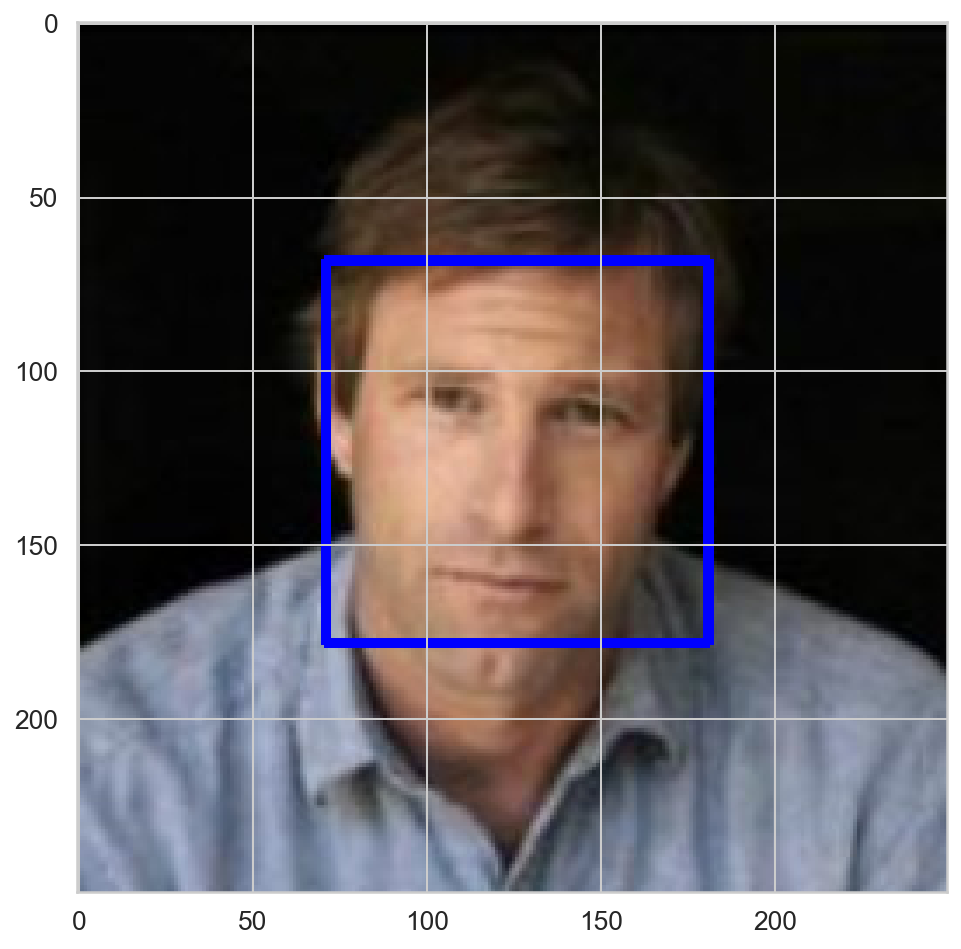

In [43]:
# extract pre-trained face detector
face_cascade = cv2.CascadeClassifier('../input/haarcascades/haarcascade_frontalface_alt.xml')

# load color (BGR) image
img = cv2.imread(human_files[0])
# convert BGR image to grayscale
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# find faces in image
faces = face_cascade.detectMultiScale(gray)

# print number of faces detected in the image
print('Number of faces detected:', len(faces))

# get bounding box for each detected face
for (x,y,w,h) in faces:
    # add bounding box to color image
    cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,0),2)
    
# convert BGR image to RGB for plotting
cv_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# display the image, along with bounding box
plt.imshow(cv_rgb)
plt.show()

Before using any of the face detectors, it is standard procedure to convert the images to grayscale.  The `detectMultiScale` function executes the classifier stored in `face_cascade` and takes the grayscale image as a parameter.  

In the above code, `faces` is a numpy array of detected faces, where each row corresponds to a detected face.  Each detected face is a 1D array with four entries that specifies the bounding box of the detected face.  The first two entries in the array (extracted in the above code as `x` and `y`) specify the horizontal and vertical positions of the top left corner of the bounding box.  The last two entries in the array (extracted here as `w` and `h`) specify the width and height of the box.

### Write a Human Face Detector

We can use this procedure to write a function that returns `True` if a human face is detected in an image and `False` otherwise.  This function, aptly named `face_detector`, takes a string-valued file path to an image as input and appears in the code block below.

In [51]:
# returns "True" if face is detected in image stored at img_path
def face_detector(img_path):
    img = cv2.imread(img_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray)
    return len(faces) > 0

### (IMPLEMENTATION) Assess the Human Face Detector

__Question 1:__ Use the code cell below to test the performance of the `face_detector` function.  
- What percentage of the first 100 images in `human_files` have a detected human face?  
- What percentage of the first 100 images in `dog_files` have a detected human face? 

Ideally, we would like 100% of human images with a detected face and 0% of dog images with a detected face.  You will see that our algorithm falls short of this goal, but still gives acceptable performance.  We extract the file paths for the first 100 images from each of the datasets and store them in the numpy arrays `human_files_short` and `dog_files_short`.

In [52]:
def detect_faces(img_paths):
    faces_detected = np.zeros(len(img_paths))
    for i in range(len(img_paths)):
        faces_detected[i] = face_detector(img_paths[i])
    return faces_detected

__Answer:__ 
96% and 18% respectively

In [53]:
human_files_short = human_files[:100]
dog_files_short = dog_files[:100]

# -#-# Do NOT modify the code above this line. #-#-#

In [54]:
## TODO: Test the performance of the face_detector algorithm
## on the images in human_files_short and dog_files_short.
faces_detected_human = detect_faces(human_files_short)
faces_detected_dog = detect_faces(dog_files_short)

In [55]:
print(f"{np.mean(faces_detected_human)*100:.3f}% of human faces found")
print(f"{np.mean(faces_detected_dog)*100:.3f}% of dogs confused with humans")

96.000% of human faces found
18.000% of dogs confused with humans


We suggest the face detector from OpenCV as a potential way to detect human images in your algorithm, but you are free to explore other approaches, especially approaches that make use of deep learning :).  Please use the code cell below to design and test your own face detection algorithm.  If you decide to pursue this _optional_ task, report performance on `human_files_short` and `dog_files_short`.

In [56]:
### (Optional)
### TODO: Test performance of another face detection algorithm.
### Feel free to use as many code cells as needed.

---
<a id='step2'></a>
## Step 2: Detect Dogs

In this section, we use a [pre-trained model](http://pytorch.org/docs/master/torchvision/models.html) to detect dogs in images.  

### Obtain Pre-trained VGG-16 Model

The code cell below downloads the VGG-16 model, along with weights that have been trained on [ImageNet](http://www.image-net.org/), a very large, very popular dataset used for image classification and other vision tasks.  ImageNet contains over 10 million URLs, each linking to an image containing an object from one of [1000 categories](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a).  

In [57]:
# define VGG16 model
VGG16 = models.vgg16(pretrained=True)

# check if CUDA is available
use_cuda = torch.cuda.is_available()

Given an image, this pre-trained VGG-16 model returns a prediction (derived from the 1000 possible categories in ImageNet) for the object that is contained in the image.

### (IMPLEMENTATION) Making Predictions with a Pre-trained Model

In the next code cell, you will write a function that accepts a path to an image (such as `'dogImages/train/001.Affenpinscher/Affenpinscher_00001.jpg'`) as input and returns the index corresponding to the ImageNet class that is predicted by the pre-trained VGG-16 model.  The output should always be an integer between 0 and 999, inclusive.

Before writing the function, make sure that you take the time to learn  how to appropriately pre-process tensors for pre-trained models in the [PyTorch documentation](http://pytorch.org/docs/stable/torchvision/models.html).

In [58]:
normalize = T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])

In [59]:
preprocess = T.Compose([T.Resize(256), T.CenterCrop(224), T.ToTensor(), normalize])

In [60]:
VGG16 = VGG16.eval()

In [61]:
def VGG16_predict(img_path):
    """
    Use pre-trained VGG-16 model to obtain index corresponding to
    predicted ImageNet class for image at specified path

    Args:
        img_path: path to an image

    Returns:
        Index corresponding to VGG-16 model's prediction
    """

    img = Image.open(img_path)
    img_tensor = preprocess(img)
    img_tensor.unsqueeze_(0)

    with torch.no_grad():
        out = VGG16(img_tensor)

    return out.argmax().numpy()

### (IMPLEMENTATION) Write a Dog Detector

While looking at the [dictionary](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a), you will notice that the categories corresponding to dogs appear in an uninterrupted sequence and correspond to dictionary keys 151-268, inclusive, to include all categories from `'Chihuahua'` to `'Mexican hairless'`.  Thus, in order to check to see if an image is predicted to contain a dog by the pre-trained VGG-16 model, we need only check if the pre-trained model predicts an index between 151 and 268 (inclusive).

Use these ideas to complete the `dog_detector` function below, which returns `True` if a dog is detected in an image (and `False` if not).

In [62]:
### returns "True" if a dog is detected in the image stored at img_path
def dog_detector(img_path):

    idx = VGG16_predict(img_path)
    ## TODO: Complete the function.

    return idx >= 151 and idx <= 268

### (IMPLEMENTATION) Assess the Dog Detector

__Question 2:__ Use the code cell below to test the performance of your `dog_detector` function.  
- What percentage of the images in `human_files_short` have a detected dog?  
- What percentage of the images in `dog_files_short` have a detected dog?

__Answer:__ 
0% and 94% respectively

In [63]:
### TODO: Test the performance of the dog_detector function
### on the images in human_files_short and dog_files_short.
dogs_detected_correctly = [dog_detector(img_path) for img_path in dog_files_short]
dogs_detected_incorrectly = [dog_detector(img_path) for img_path in human_files_short]

In [64]:
tpr_vgg16 = np.mean(dogs_detected_correctly)
fpr_vgg16 = np.mean(dogs_detected_incorrectly)

print(f"VGG16: {fpr_vgg16 * 100:.3f}% of humans confused with dogs")
print(f"VGG16: {tpr_vgg16 * 100:.3f}% dogs correctly identified")

VGG16: 0.000% of humans confused with dogs
VGG16: 94.000% dogs correctly identified


We suggest VGG-16 as a potential network to detect dog images in your algorithm, but you are free to explore other pre-trained networks (such as [Inception-v3](http://pytorch.org/docs/master/torchvision/models.html#inception-v3), [ResNet-50](http://pytorch.org/docs/master/torchvision/models.html#id3), etc).  Please use the code cell below to test other pre-trained PyTorch models.  If you decide to pursue this _optional_ task, report performance on `human_files_short` and `dog_files_short`.

In [21]:
### (Optional) 
### TODO: Report the performance of another pre-trained network.
### Feel free to use as many code cells as needed.

---
<a id='step3'></a>
## Step 3: Create a CNN to Classify Dog Breeds (from Scratch)

Now that we have functions for detecting humans and dogs in images, we need a way to predict breed from images.  In this step, you will create a CNN that classifies dog breeds.  You must create your CNN _from scratch_ (so, you can't use transfer learning _yet_!), and you must attain a test accuracy of at least 10%.  In Step 4 of this notebook, you will have the opportunity to use transfer learning to create a CNN that attains greatly improved accuracy.

We mention that the task of assigning breed to dogs from images is considered exceptionally challenging.  To see why, consider that *even a human* would have trouble distinguishing between a Brittany and a Welsh Springer Spaniel.  

Brittany | Welsh Springer Spaniel
- | - 
<img src="images/Brittany_02625.jpg" width="100"> | <img src="images/Welsh_springer_spaniel_08203.jpg" width="200">

It is not difficult to find other dog breed pairs with minimal inter-class variation (for instance, Curly-Coated Retrievers and American Water Spaniels).  

Curly-Coated Retriever | American Water Spaniel
- | -
<img src="images/Curly-coated_retriever_03896.jpg" width="200"> | <img src="images/American_water_spaniel_00648.jpg" width="200">


Likewise, recall that labradors come in yellow, chocolate, and black.  Your vision-based algorithm will have to conquer this high intra-class variation to determine how to classify all of these different shades as the same breed.  

Yellow Labrador | Chocolate Labrador | Black Labrador
- | -
<img src="images/Labrador_retriever_06457.jpg" width="150"> | <img src="images/Labrador_retriever_06455.jpg" width="240"> | <img src="images/Labrador_retriever_06449.jpg" width="220">

We also mention that random chance presents an exceptionally low bar: setting aside the fact that the classes are slightly imabalanced, a random guess will provide a correct answer roughly 1 in 133 times, which corresponds to an accuracy of less than 1%.  

Remember that the practice is far ahead of the theory in deep learning.  Experiment with many different architectures, and trust your intuition.  And, of course, have fun!

### Exploratory Data analysis

Firstly, distribution of image size ratio

In [22]:
df_size = pd.DataFrame(columns=["rows", "columns"])

In [23]:
for i, f in enumerate(dog_files):
    shape = cv2.imread(f).shape
    df_size.loc[i] = [shape[0], shape[1]]

In [24]:
df_size["ratio"] = df_size["rows"] / df_size["columns"]

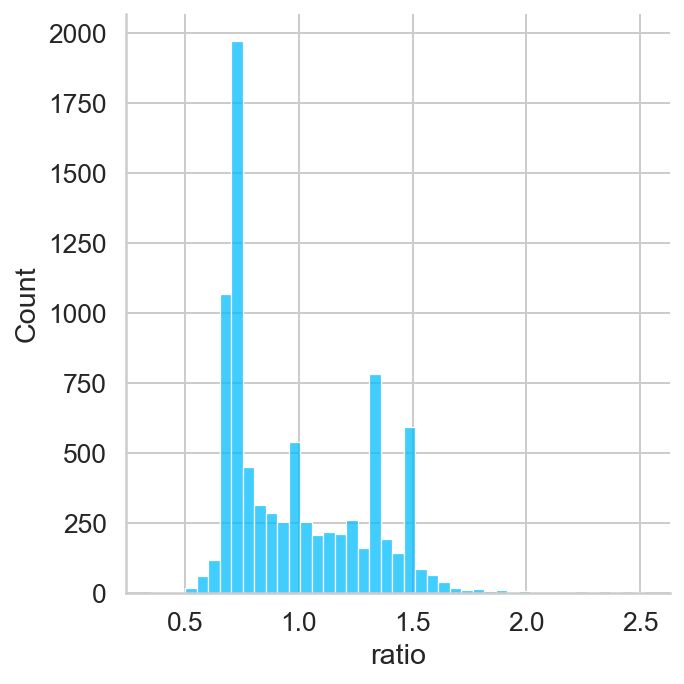

In [25]:
sns.displot(df_size, x="ratio")

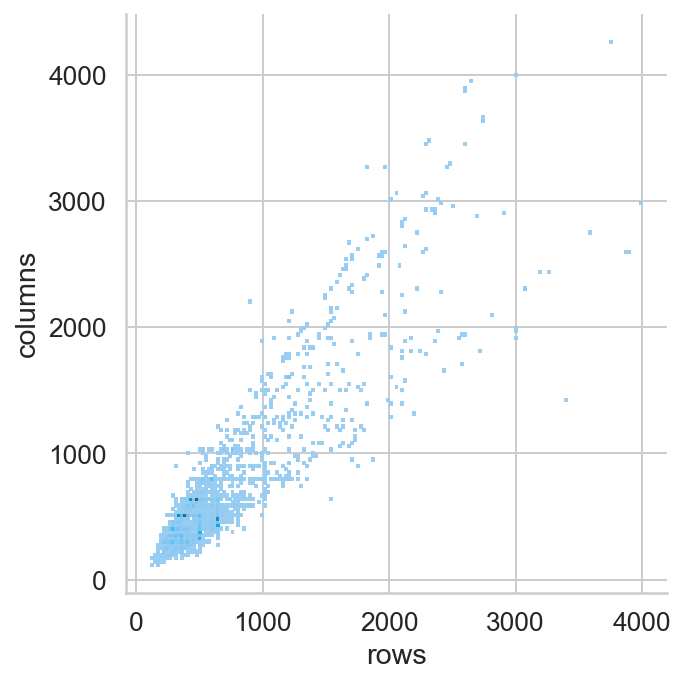

In [26]:
sns.displot(df_size, x="rows", y="columns")

Secondly, distribution of classes

In [22]:
breed_folder = np.array(glob("../input/dogImages/train/*"))
list_count = []

for i in breed_folder:
    list_count.append(len(os.listdir(i)))

C:\Users\Luca\miniconda3\envs\cv\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:>

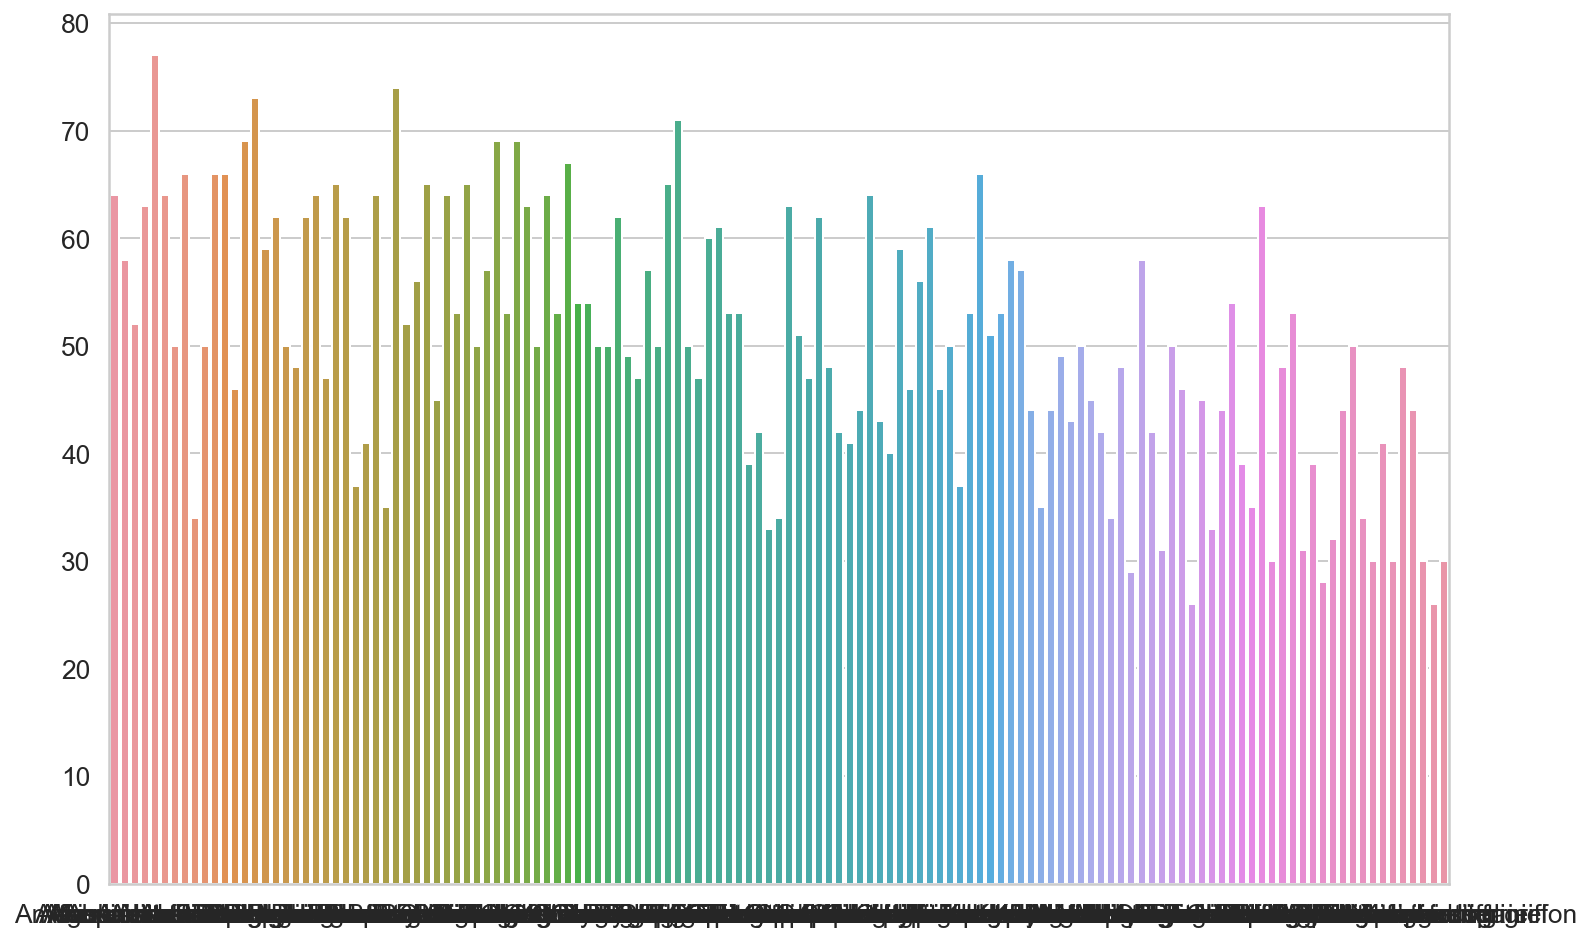

In [25]:
sns.barplot(class_names, list_count)

### (IMPLEMENTATION) Specify Data Loaders for the Dog Dataset

Use the code cell below to write three separate [data loaders](http://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader) for the training, validation, and test datasets of dog images (located at `dogImages/train`, `dogImages/valid`, and `dogImages/test`, respectively).  You may find [this documentation on custom datasets](http://pytorch.org/docs/stable/torchvision/datasets.html) to be a useful resource.  If you are interested in augmenting your training and/or validation data, check out the wide variety of [transforms](http://pytorch.org/docs/stable/torchvision/transforms.html?highlight=transform)!

In [8]:
DATA_DIR = os.path.join("..", "input", "dogImages")
DATASETS = ["train", "valid", "test"]

In [9]:
batch_size = 20
num_workers = 4

In [10]:
norm_mean = [0.485, 0.456, 0.406]
norm_std = [0.229, 0.224, 0.225]

In [11]:
transforms = {
    "train": T.Compose(
        [
            T.RandomResizedCrop(224),
            T.RandomHorizontalFlip(),
            T.RandomRotation(10),
            T.ToTensor(),
            T.Normalize(mean=norm_mean, std=norm_std),
        ]
    ),
    "valid": T.Compose(
        [
            T.Resize(256),
            T.CenterCrop(224),
            T.ToTensor(),
            T.Normalize(mean=norm_mean, std=norm_std),
        ]
    ),
}

In [12]:
transforms["test"] = transforms["valid"]

In [13]:
image_datasets = {
    d: datasets.ImageFolder(os.path.join(DATA_DIR, d), transforms[d]) for d in DATASETS
}

In [14]:
loaders_data = {
    x: torch.utils.data.DataLoader(
        image_datasets[x], batch_size=batch_size, shuffle=True, num_workers=num_workers
    )
    for x in DATASETS
}

In [15]:
dataset_sizes = {d: len(image_datasets[d]) for d in DATASETS}
class_names = image_datasets["train"].classes

dataset_sizes

{'train': 6679, 'valid': 835, 'test': 836}

In [16]:
n_classes = len(class_names)

**Question 3:** Describe your chosen procedure for preprocessing the data. 
- How does your code resize the images (by cropping, stretching, etc)?  What size did you pick for the input tensor, and why?
- Did you decide to augment the dataset?  If so, how (through translations, flips, rotations, etc)?  If not, why not?

**Answer**:
- The code resize the images by streching and cropping. Despite study of ratio sizes, I kept 224 to be able to compare perfomances to fine-tuned pre-trained models.
- The dataset is augmented with random resized crop, random horizontal flip and small random rotation. Vertical flip does not make sense for dogs and ColorJitter was more computationaly demanding than effective

### (IMPLEMENTATION) Model Architecture

Create a CNN to classify dog breed.  Use the template in the code cell below.

In [43]:
# define the CNN architecture
class Net(nn.Module):
    ### TODO: choose an architecture, and complete the class
    def __init__(self):
        super(Net, self).__init__()
        ## Define layers of a CNN
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, padding=1)

        self.fc1 = nn.Linear(28 * 28 * 64, 500)
        self.fc2 = nn.Linear(500, len(class_names))
        self.dropout = nn.Dropout(0.25)
        self.batch_norm = nn.BatchNorm1d(num_features=500)

    def forward(self, x):
        ## Define forward behavior
        out = F.max_pool2d(F.relu(self.conv1(x)), 2)
        out = F.max_pool2d(F.relu(self.conv2(out)), 2)
        out = F.max_pool2d(F.relu(self.conv3(out)), 2)

        out = out.view(out.size(0), -1)
        out = self.dropout(out)
        out = F.relu(self.batch_norm(self.fc1(out)))
        out = self.dropout(out)
        out = self.fc2(out)

        return out


# -#-# You do NOT have to modify the code below this line. #-#-#

# instantiate the CNN
model_scratch = Net()

# move tensors to GPU if CUDA is available
if use_cuda:
    model_scratch.cuda()

__Question 4:__ Outline the steps you took to get to your final CNN architecture and your reasoning at each step.  

__Answer:__ 
It is a basic CNN that I made deeper until reaching requested performance.

### (IMPLEMENTATION) Specify Loss Function and Optimizer

Use the next code cell to specify a [loss function](http://pytorch.org/docs/stable/nn.html#loss-functions) and [optimizer](http://pytorch.org/docs/stable/optim.html).  Save the chosen loss function as `criterion_scratch`, and the optimizer as `optimizer_scratch` below.

In [47]:
### TODO: select loss function
criterion_scratch = torch.nn.CrossEntropyLoss()

### TODO: select optimizer
optimizer_scratch = optim.SGD(model_scratch.parameters(), lr=0.001, momentum=0.9)

### (IMPLEMENTATION) Train and Validate the Model

Train and validate your model in the code cell below.  [Save the final model parameters](http://pytorch.org/docs/master/notes/serialization.html) at filepath `'model_scratch.pt'`.

In [7]:
def train(n_epochs, loaders, model, optimizer, criterion, use_cuda, save_path):
    """returns trained model"""
    # initialize tracker for minimum validation loss
    valid_loss_min = np.Inf

    for epoch in range(1, n_epochs + 1):
        # initialize variables to monitor training and validation loss
        train_loss = 0.0
        valid_loss = 0.0

        ###################
        # train the model #
        ###################
        model.train()
        for batch_idx, (data, target) in enumerate(loaders["train"]):
            # move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()
            ## find the loss and update the model parameters accordingly
            ## record the average training loss, using something like
            ## train_loss = train_loss + ((1 / (batch_idx + 1)) * (loss.data - train_loss))
            optimizer.zero_grad()

            outputs = model(data)
            loss = criterion(outputs, target)

            loss.backward()
            optimizer.step()

            train_loss = train_loss + ((1 / (batch_idx + 1)) * (loss.data - train_loss))

        ######################
        # validate the model #
        ######################
        model.eval()
        for batch_idx, (data, target) in enumerate(loaders["valid"]):
            # move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()
            ## update the average validation loss
            outputs = model(data)
            loss = criterion(outputs, target)

            valid_loss = valid_loss + ((1 / (batch_idx + 1)) * (loss.data - valid_loss))

        # print training/validation statistics
        print(
            "Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}".format(
                epoch, train_loss, valid_loss
            )
        )

        ## TODO: save the model if validation loss has decreased
        if valid_loss < valid_loss_min:
            torch.save(model.state_dict(), "../models/{}".format(save_path))
            valid_loss_min = valid_loss

    # return trained model
    return model

In [150]:
# train the model
model_scratch = train(100, loaders_data, model_scratch, optimizer_scratch, 
                      criterion_scratch, use_cuda, 'model_scratch.pt')

Epoch: 1 	Training Loss: 4.783016 	Validation Loss: 4.546968
Epoch: 2 	Training Loss: 4.596862 	Validation Loss: 4.421182
Epoch: 3 	Training Loss: 4.466127 	Validation Loss: 4.276837
Epoch: 4 	Training Loss: 4.378221 	Validation Loss: 4.237943
Epoch: 5 	Training Loss: 4.320302 	Validation Loss: 4.134120
Epoch: 6 	Training Loss: 4.265438 	Validation Loss: 4.055861
Epoch: 7 	Training Loss: 4.199855 	Validation Loss: 4.053327
Epoch: 8 	Training Loss: 4.142603 	Validation Loss: 3.983850
Epoch: 9 	Training Loss: 4.120362 	Validation Loss: 3.942163
Epoch: 10 	Training Loss: 4.074160 	Validation Loss: 3.907541
Epoch: 11 	Training Loss: 4.015599 	Validation Loss: 3.844788
Epoch: 12 	Training Loss: 3.962351 	Validation Loss: 3.862998
Epoch: 13 	Training Loss: 3.938823 	Validation Loss: 3.763802
Epoch: 14 	Training Loss: 3.887773 	Validation Loss: 3.726616
Epoch: 15 	Training Loss: 3.837574 	Validation Loss: 3.724873
Epoch: 16 	Training Loss: 3.808973 	Validation Loss: 3.676643
Epoch: 17 	Traini

In [44]:
# load the model that got the best validation accuracy
model_scratch.load_state_dict(torch.load("../models/model_scratch.pt"))

<All keys matched successfully>

### (IMPLEMENTATION) Test the Model

Try out your model on the test dataset of dog images.  Use the code cell below to calculate and print the test loss and accuracy.  Ensure that your test accuracy is greater than 10%.

In [8]:
def test(loaders, model, criterion, use_cuda):

    # monitor test loss and accuracy
    test_loss = 0.0
    correct = 0.0
    total = 0.0

    model.eval()
    for batch_idx, (data, target) in enumerate(loaders["test"]):
        # move to GPU
        if use_cuda:
            data, target = data.cuda(), target.cuda()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the loss
        loss = criterion(output, target)
        # update average test loss
        test_loss = test_loss + ((1 / (batch_idx + 1)) * (loss.data - test_loss))
        # convert output probabilities to predicted class
        pred = output.data.max(1, keepdim=True)[1]
        # compare predictions to true label
        correct += np.sum(np.squeeze(pred.eq(target.data.view_as(pred))).cpu().numpy())
        total += data.size(0)

    print("Test Loss: {:.6f}\n".format(test_loss))

    print(
        "\nTest Accuracy: %2d%% (%2d/%2d)" % (100.0 * correct / total, correct, total)
    )

In [48]:
# call test function
test(loaders_data, model_scratch, criterion_scratch, use_cuda)

Test Loss: 2.806062


Test Accuracy: 30% (254/836)


---
<a id='step4'></a>
## Step 4: Create a CNN to Classify Dog Breeds (using Transfer Learning)

You will now use transfer learning to create a CNN that can identify dog breed from images.  Your CNN must attain at least 60% accuracy on the test set.

### (IMPLEMENTATION) Specify Data Loaders for the Dog Dataset

Use the code cell below to write three separate [data loaders](http://pytorch.org/docs/master/data.html#torch.utils.data.DataLoader) for the training, validation, and test datasets of dog images (located at `dogImages/train`, `dogImages/valid`, and `dogImages/test`, respectively). 

If you like, **you are welcome to use the same data loaders from the previous step**, when you created a CNN from scratch.

### (IMPLEMENTATION) Model Architecture

Use transfer learning to create a CNN to classify dog breed.  Use the code cell below, and save your initialized model as the variable `model_transfer`.

In [28]:
model_transfer = models.densenet121(pretrained=True)
for param in model_transfer.parameters():
    param.requires_grad = False
num_ftrs = model_transfer.classifier.in_features
model_transfer.classifier = nn.Linear(num_ftrs, n_classes)

# if GPU is available, move the model to GPU
if use_cuda:
    model_transfer.cuda()
print(model_transfer)

DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu

__Question 5:__ Outline the steps you took to get to your final CNN architecture and your reasoning at each step.  Describe why you think the architecture is suitable for the current problem.

__Answer:__ 
I initially tried ResNet-152 and DenseNet-161. I finally used Densenet-121 to have a lighter model to be deployed and only sacrificing 2% of accuracy

### (IMPLEMENTATION) Specify Loss Function and Optimizer

Use the next code cell to specify a [loss function](http://pytorch.org/docs/master/nn.html#loss-functions) and [optimizer](http://pytorch.org/docs/master/optim.html).  Save the chosen loss function as `criterion_transfer`, and the optimizer as `optimizer_transfer` below.

In [29]:
criterion_transfer = nn.CrossEntropyLoss()
optimizer_transfer = optim.SGD(
    model_transfer.classifier.parameters(), lr=0.001, momentum=0.9
)

### (IMPLEMENTATION) Train and Validate the Model

Train and validate your model in the code cell below.  [Save the final model parameters](http://pytorch.org/docs/master/notes/serialization.html) at filepath `'model_transfer.pt'`.

In [25]:
# train the model
model_transfer = train(
    100,
    loaders_data,
    model_transfer,
    optimizer_transfer,
    criterion_transfer,
    use_cuda,
    "ft_densenet121.pt",
)

Epoch: 1 	Training Loss: 0.666869 	Validation Loss: 0.367175
Epoch: 2 	Training Loss: 0.703848 	Validation Loss: 0.370706
Epoch: 3 	Training Loss: 0.722781 	Validation Loss: 0.366812
Epoch: 4 	Training Loss: 0.691230 	Validation Loss: 0.371315
Epoch: 5 	Training Loss: 0.710198 	Validation Loss: 0.364417
Epoch: 6 	Training Loss: 0.688414 	Validation Loss: 0.367620
Epoch: 7 	Training Loss: 0.699640 	Validation Loss: 0.359034
Epoch: 8 	Training Loss: 0.698306 	Validation Loss: 0.366347
Epoch: 9 	Training Loss: 0.677581 	Validation Loss: 0.365305
Epoch: 10 	Training Loss: 0.688921 	Validation Loss: 0.363729
Epoch: 11 	Training Loss: 0.707580 	Validation Loss: 0.354498
Epoch: 12 	Training Loss: 0.699391 	Validation Loss: 0.369623
Epoch: 13 	Training Loss: 0.687198 	Validation Loss: 0.368946
Epoch: 14 	Training Loss: 0.693846 	Validation Loss: 0.371904
Epoch: 15 	Training Loss: 0.679252 	Validation Loss: 0.372383
Epoch: 16 	Training Loss: 0.695370 	Validation Loss: 0.363728
Epoch: 17 	Traini

In [30]:
# load the model that got the best validation accuracy (uncomment the line below)
model_transfer.load_state_dict(torch.load("../models/ft_densenet121.pt"))

<All keys matched successfully>

### (IMPLEMENTATION) Test the Model

Try out your model on the test dataset of dog images. Use the code cell below to calculate and print the test loss and accuracy.  Ensure that your test accuracy is greater than 60%.

In [27]:
test(loaders_data, model_transfer, criterion_transfer, use_cuda)

Test Loss: 0.408416


Test Accuracy: 87% (728/836)


### (IMPLEMENTATION) Predict Dog Breed with the Model

Write a function that takes an image path as input and returns the dog breed (`Affenpinscher`, `Afghan hound`, etc) that is predicted by your model.  

In [32]:
# list of class names by index, i.e. a name can be accessed like class_names[0]
class_names = [item[4:].replace("_", " ") for item in image_datasets["train"].classes]

In [33]:
preprocess = T.Compose(
    [
        T.Resize(256),
        T.CenterCrop(224),
        T.ToTensor(),
        T.Normalize(mean=norm_mean, std=norm_std),
    ]
)

In [34]:
model_transfer.cpu()
model_transfer=model_transfer.eval()

In [35]:
### TODO: Write a function that takes a path to an image as input
### and returns the dog breed that is predicted by the model.


def predict_breed_transfer(img_path):
    # load the image and return the predicted breed
    img = Image.open(img_path)
    img_tensor = preprocess(img)
    img_tensor.unsqueeze_(0)

    with torch.no_grad():
        out = model_transfer(img_tensor)

    return class_names[out.argmax().numpy()]

In [48]:
predict_breed_transfer(dog_files_short[0]) 

'Affenpinscher'

---
<a id='step5'></a>
## Step 5: Write your Algorithm

Write an algorithm that accepts a file path to an image and first determines whether the image contains a human, dog, or neither.  Then,
- if a __dog__ is detected in the image, return the predicted breed.
- if a __human__ is detected in the image, return the resembling dog breed.
- if __neither__ is detected in the image, provide output that indicates an error.

You are welcome to write your own functions for detecting humans and dogs in images, but feel free to use the `face_detector` and `dog_detector` functions developed above.  You are __required__ to use your CNN from Step 4 to predict dog breed.  

Some sample output for our algorithm is provided below, but feel free to design your own user experience!

![Sample Human Output](images/sample_human_output.png)


### (IMPLEMENTATION) Write your Algorithm

In [68]:
### TODO: Write your algorithm.
### Feel free to use as many code cells as needed.


def run_app(img_path):

    if dog_detector(img_path):
        breed = predict_breed_transfer(img_path)
        print("this dog looks like a {}".format(breed))

    elif face_detector(img_path):
        breed = predict_breed_transfer(img_path)
        print("this human looks like a {}".format(breed))

    else:
        print("no human nor dog was detected")
    ## handle cases for a human face, dog, and neither

---
<a id='step6'></a>
## Step 6: Test Your Algorithm

In this section, you will take your new algorithm for a spin!  What kind of dog does the algorithm think that _you_ look like?  If you have a dog, does it predict your dog's breed accurately?  If you have a cat, does it mistakenly think that your cat is a dog?

### (IMPLEMENTATION) Test Your Algorithm on Sample Images!

Test your algorithm at least six images on your computer.  Feel free to use any images you like.  Use at least two human and two dog images.  

__Question 6:__ Is the output better than you expected :) ?  Or worse :( ?  Provide at least three possible points of improvement for your algorithm.

__Answer:__
- fine-tuning small CNN to detect humans, dogs and others
- fine-tuning entire CNN for dog breeds
- Collecting more pictures as deployed model struggling on bad images

In [69]:
## TODO: Execute your algorithm from Step 6 on
## at least 6 images on your computer.
## Feel free to use as many code cells as needed.

## suggested code, below
for file in np.hstack((human_files[:3], dog_files[:3])):
    run_app(file)

this human looks like a Cardigan welsh corgi
this human looks like a Welsh springer spaniel
no human nor dog was detected
this dog looks like a Affenpinscher
this dog looks like a Affenpinscher
this dog looks like a Affenpinscher
